In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
#import matplotlib
#matplotlib.use('GtkAgg')
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def normalize(df):
    result = df.copy()
    print(len(result.transpose()))
    for feature_name in range(len(result.transpose())):
        max_value = df[1:1800, feature_name].max()
        min_value = df[1:1800, feature_name].min()
        a = 1 / (max_value-min_value)
        b = 1 - a * max_value
        result[1:1800,feature_name] = (df[1:1800, feature_name] * a + b)
    return result

In [18]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        #self.lstm1 = nn.LSTMCell(1, 51)
        #self.lstm2 = nn.LSTMCell(51, 51)
        #self.linear = nn.Linear(51, 1)
        
        self.lstm1 = nn.LSTMCell(1798, 51)
        self.lstm2 = nn.LSTMCell(51, 3)
        self.linear = nn.Linear(3, 3)

    def forward(self, input, future = 0):
        outputs = []
        #input = input.transpose(1,0)
        #print(input)
        #h_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        #c_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        #h_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        #c_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t = Variable(torch.zeros(1, 51).double(), requires_grad=False)
        c_t = Variable(torch.zeros(1, 51).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(1, 3).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(1, 3).double(), requires_grad=False)
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            #print(i)
            #print('input:', input_t.transpose(1,0).size())   
            h_t, c_t = self.lstm1(input_t.transpose(1,0), (h_t, c_t))
            #print('ht:', h_t.size())
            #print('ct:', c_t.size())  

            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
            #print('ht2:', h_t2)
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


243
58
Train Error:  1.14487  Val Error:  1.14207
Train Error:  1.13847  Val Error:  1.13235
Train Error:  1.13361  Val Error:  1.12942
Train Error:  1.12711  Val Error:  1.11833
Train Error:  1.11546  Val Error:  1.10953
Train Error:  1.10602  Val Error:  1.10742
Train Error:  1.0948  Val Error:  1.09298
Train Error:  1.0846  Val Error:  1.07945
Train Error:  1.07275  Val Error:  1.06934
Train Error:  1.06218  Val Error:  1.06146
Train Error:  1.0525  Val Error:  1.04607
Train Error:  1.041  Val Error:  1.05045
Train Error:  1.03492  Val Error:  1.02643
Train Error:  1.0279  Val Error:  1.02948
Train Error:  1.02227  Val Error:  1.02621
Train Error:  1.01638  Val Error:  1.02059
Train Error:  1.00963  Val Error:  1.01513
Train Error:  1.00625  Val Error:  1.00544
Train Error:  1.00056  Val Error:  0.998188
Train Error:  0.999179  Val Error:  1.00395
Train Error:  0.994759  Val Error:  0.998315
Train Error:  0.994227  Val Error:  0.999042
Train Error:  0.990355  Val Error:  1.00002
Tra

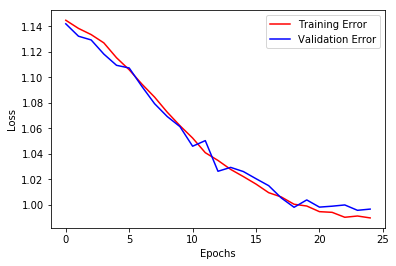

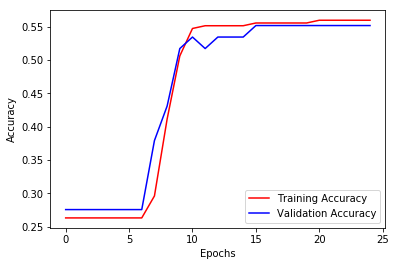

In [27]:
if __name__ == '__main__':
    # set random seed to 0
    np.random.seed(0)
    torch.manual_seed(0)
    
    #print(range(len(data)))
    #print(len(datat))
    data0 = pd.read_csv('arrhythmia5_TrainData.csv', header=None, low_memory=False)
    y = data0.values.astype(float)
    z = normalize(y)
    
    
    valdata0 = pd.read_csv('arrhythmia5_ValData.csv', header=None, low_memory=False)
    valy = valdata0.values.astype(float)
    valz = normalize(valy)
    
    epocha = []
    trainsumerrora = []
    valsumerrora = []
    accuracya = []
    accuracya1 = []
   
    seq = Sequence()
    seq.double()
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(seq.parameters(), lr=0.01, momentum = 0.9)
    mepoch = 25
        
    
    
    for epoch in range(0, mepoch):
        x = np.random.permutation(z.transpose())
        data1 = torch.DoubleTensor(x.transpose())
        input_date = data1[1:1799]
        labels = data1[0]
                  
        valx = np.random.permutation(valz.transpose())
        valdata1 = torch.DoubleTensor(valx.transpose())
        valinput_date = valdata1[1:1799]
        vallabels = valdata1[0]
    
        target_matrix = torch.zeros(3,243)
        valtarget_matrix = torch.zeros(3,58)
    
        for batch in range(0, 243):
            target_matrix[int(labels[batch]), batch] = 1
    
        for batch in range(0, 58):
            valtarget_matrix[int(vallabels[batch]), batch] = 1
    
        targetV = Variable(target_matrix.double())
        valtargetV = Variable(valtarget_matrix.double())
        
        optimizer.zero_grad()
        out = seq(Variable(input_date))
        loss = criterion(out.squeeze().float(), torch.max(targetV.squeeze(),0)[1])
        loss.backward()
        optimizer.step()
        
        outval = seq(Variable(valinput_date))
        valloss = criterion(outval.squeeze().float(), torch.max(valtargetV.squeeze(),0)[1])
        
        epocha.append(epoch)        
        trainsumerrora.append(loss[0].data.numpy()[0])        
        valsumerrora.append(valloss[0].data.numpy()[0])
        
        count = 0
        count1 = 0
        for batch in range(243):
            if torch.max(targetV.squeeze(),0)[1][batch] == torch.max(out.squeeze(),1)[1][batch]:
                count1 = count1 + 1
                        
        accuracy1 = count1/243
        
        for batch in range(58):
            if torch.max(valtargetV.squeeze(),0)[1][batch] == torch.max(outval.squeeze(),1)[1][batch]:
                count = count + 1
                
        accuracy = count / 58
        
        accuracya.append(accuracy)
        accuracya1.append(accuracy1)
        
        print("Train Error: ",loss[0].data.numpy()[0], " Val Error: ", valloss[0].data.numpy()[0])
        
    #print(trainsumerrora)
    #print(epocha)
    
    plt.figure(1)
    fig, ax = plt.subplots()
    ax.plot(epocha, trainsumerrora, 'r', label = 'Training Error')
    ax.plot(epocha, valsumerrora, 'b', label = 'Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    legend = ax.legend()
    plt.show()
        
    plt.figure(2)
    plt.plot(epocha, accuracya1, 'r', label = 'Training Accuracy')
    plt.plot(epocha, accuracya, 'b', label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    legend = plt.legend()
    plt.show()
    